## Introduction

This notebook builds a joint distribution model between two variables:
1. Daily Average Base Fee
2. Daily Total Gas Used

DailyTotalGas can be interpreted as a demand signal for block space over the course of the day. This is in units of Gas.  To convert to units of FIL, we need base_fee.  base_fee is a parameter that evolves epoch to epoch, but in this notebook, we want to explore at the time-scale of days. We therefore aggregate base_fee into a day, by averaging the base_fee over the day.

We begin by downloading real data from starboard, and building a copula model. We observe that the downloaded dataset does not contain base fee in low total gas usage regimes. Since DirectFIL+ is going to reduce the gas usage substantially, leading to a lower base fee, our model needs to have an accurate representation of that data.

To account for this, we build a time-series model which models the normalized gas-usage of a block, based on historical data. We then generate realizations from this time-series model, which approximates the epoch level dynamics of gas usage.  We then alter the normalized gas usage such that it corresponds to lower gas regimes, and generate realizations of base_fee, using the EIP-1559 formula. Those realizations are then aggregated into a synthetic dataset.

The synthetic dataset is augmented w/ the real dataset from starboard, to now have data points for base_fee in low TotalGas used regimes.  We then build a second copula model with this augmented dataset.  This is the model that will be used for predicting the average base_fee, given TotalGas usage.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pystarboard.data_spacescope as dss
from datetime import date, timedelta, datetime
import pandas as pd
import numpy as np
import numpy.random
from statsmodels.distributions.empirical_distribution import ECDF, monotone_fn_inverter

import gas_models
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# for modeling base-fee to total-gas-usage, we can use more data for training than learning the PSD
# gas usage b/c we want to create a general mapping between basefee and total-gas-usage, regardless
# of message type
training_start_date = date(2021, 12, 1)
training_end_date = date.today()-timedelta(days=3)
df_basefee = gas_models.get_basefee_spacescope(training_start_date, training_end_date)
df_basefee_daily = df_basefee.groupby(df_basefee['hour_date'].dt.date).mean()
gas_train_df = gas_models.get_daily_gasusage_training_data(training_start_date, training_end_date)
train_df = pd.DataFrame()
train_df['daily_base_fee'] = df_basefee_daily['unit_base_fee'].values
train_df['total_gas_used'] = gas_train_df['total_gas_used'].values

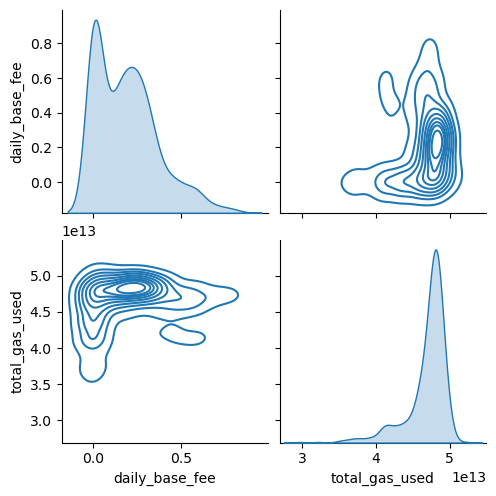

In [4]:
sns.pairplot(train_df, kind='kde')

In [5]:
# Build a copula joint-distribution model between the total_gas_used and base_fee using Starboard data
copula_model = gas_models.BivariateCopulaModel(train_df.values)
copula_model.fit()
V = copula_model.simulate_pseudoobs(nsamp=500)

'\nNotes: notice the tail-dependence is well captured by the Copula, in the pseudo-obs space.\nHowever, in the data space, we see that the data is smoothed out a little bit.\n'

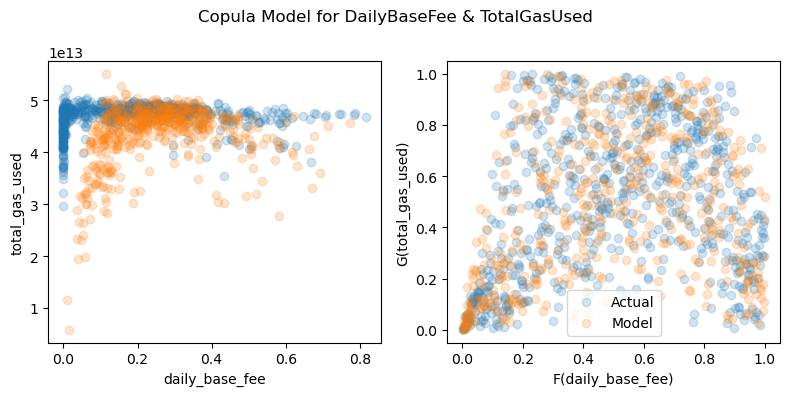

In [6]:
# plot the original pseudo-observations and the copula's for sanity checking
plt.figure(figsize=(8,4))

plt.subplot(121)
# TODO: show scatter plot in normal data scale
Y = copula_model.pobs_to_obs(V)
plt.scatter(copula_model.X[:,0], copula_model.X[:,1], alpha=0.2, label='Actual')
plt.scatter(Y[:,0], Y[:,1], alpha=0.2, label='Model')
plt.xlabel('daily_base_fee')
plt.ylabel('total_gas_used')


plt.subplot(122)
plt.scatter(copula_model.U[:,0], copula_model.U[:,1], alpha=0.2, label='Actual')
plt.scatter(V[:,0], V[:,1], alpha=0.2, label='Model')
plt.xlabel('F(daily_base_fee)')
plt.ylabel('G(total_gas_used)')
plt.legend()

plt.suptitle('Copula Model for DailyBaseFee & TotalGasUsed')
plt.tight_layout()

"""
Notes: notice the tail-dependence is well captured by the Copula, in the pseudo-obs space.
However, in the data space, we see that the data is smoothed out a little bit.
"""

'\nNote that TotalGas=10000, TotalGas=20000 have the same conditional CDF. This is due to our dataset, which lacks\nany sample data points for TotalGas < 30000.\n'

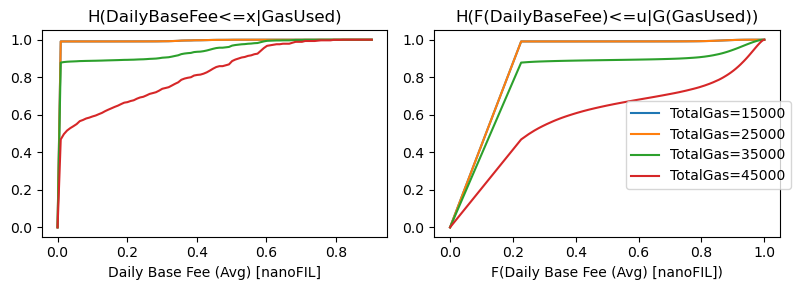

In [7]:
# generate conditional distribution functions 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))

gasused_vec = np.arange(15000, 50000, 10000)*1e9
# gasused_vec = np.asarray([10000])*1e9
for g in gasused_vec:
    marginal_var, marginal_var_pseudoobs, conditional_copula_cdf = \
        copula_model.conditional_distribution(x=None, y=g, resolution=100)
    
    ax[0].plot(marginal_var, conditional_copula_cdf)
    ax[1].plot(marginal_var_pseudoobs, conditional_copula_cdf, label='TotalGas=%d' % (g//1e9,))

ax[0].set_xlabel('Daily Base Fee (Avg) [nanoFIL]')
ax[0].set_title('H(DailyBaseFee<=x|GasUsed)')
ax[1].set_xlabel('F(Daily Base Fee (Avg) [nanoFIL])')
ax[1].set_title('H(F(DailyBaseFee)<=u|G(GasUsed))')
fig.legend(loc='outside right center')

plt.tight_layout()

"""
Note that TotalGas=10000, TotalGas=20000 have the same conditional CDF. This is due to our dataset, which lacks
any sample data points for TotalGas < 30000.
"""

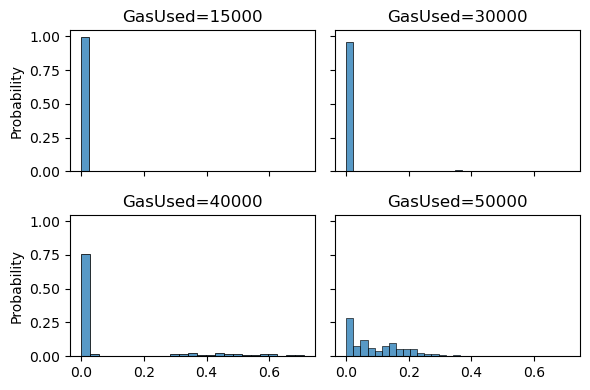

In [9]:
# we can also see the effect of lacking data from another perspective, of sampling from the conditional distribution
# for different gas values
gasused_vec = np.asarray([15000, 30000, 40000, 50000])*1e9
nsamp = 500
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(6,4))
for kk, g in enumerate(gasused_vec):
    samps_vec = copula_model.sample_conditional_distribution(x=None, y=g, resolution=100, nsamps=nsamp)

    ix,iy = np.unravel_index(kk, (2,2))
    sns.histplot(samps_vec, stat='probability', ax=ax[ix][iy], bins=25)
    ax[ix][iy].set_title('GasUsed=%d' % (g//1e9,))

plt.tight_layout()

In [10]:
# Generate data for lower total_gas regimes, using the procedure outlined above.
# First, get data from the chain for base_fee.
df_basefee_lily = gas_models.get_message_gas_economy_lily(HEIGHT=3_000_000)
df_basefee_lily=df_basefee_lily.sort_values(by='height')
df_basefee_lily=df_basefee_lily.set_index('height')
firstBlock=df_basefee_lily.index[0]
lastBlock=df_basefee_lily.index[-1]

In [11]:
df_basefee_lily.head()

,base_fee,time
height,,
3000001,3.749435e-10,2023-07-02 14:00:30
3000002,4.217095e-10,2023-07-02 14:01:00
3000003,4.425752e-10,2023-07-02 14:01:30
3000004,4.619555e-10,2023-07-02 14:02:00
3000005,4.624043e-10,2023-07-02 14:02:30


In [12]:
basefee_totalgas_tsmodel = gas_models.AvgBaseFeeTotalGasUsageARMAModel(df_basefee_lily)
basefee_totalgas_tsmodel.fit()

                               SARIMAX Results                                
Dep. Variable:               base_fee   No. Observations:               234797
Model:                 ARIMA(1, 0, 0)   Log Likelihood             -110612.739
Date:                Wed, 27 Sep 2023   AIC                         221231.479
Time:                        15:33:55   BIC                         221262.578
Sample:                             0   HQIC                        221240.569
                             - 234797                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0102      0.001    -10.219      0.000      -0.012      -0.008
ar.L1          0.1195      0.002     58.521      0.000       0.116       0.124
sigma2         0.1502      0.001    298.046      0.0

In [13]:
# generate data to fill in missing data.
# the offests are set such that we get upto the 30k gas units (units = Billions), since we have real-data for after that
# generate enough such that synthetic and real data are about matched in terms of the # of samples
desired_gas_vec = np.linspace(10000, 30000, 10)*1e9

# simulate the data for the different total gas usage
basefee_avg_day, totalgas_day = basefee_totalgas_tsmodel.sample_basefee_avgdaily_totalgas_sumdaily(
    ndays_per_realization=1, 
    nsamps_per_offset=len(train_df)//len(desired_gas_vec), 
    gt_total_vec=desired_gas_vec,
    same_basefee_within_epoch=True
)
# put this into a dataframe
train_df_synthetic = pd.DataFrame()
train_df_synthetic['daily_base_fee'] = basefee_avg_day*1e9  # convert to units of nanofil
train_df_synthetic['total_gas_used'] = totalgas_day

Building mapping between Gtilde and Gt


  0%|          | 0/10 [00:00<?, ?it/s]

[-0.74795236 -0.72046813 -0.6929839  -0.66571793 -0.63880905 -0.61190017
 -0.5849706  -0.5579698  -0.53096899 -0.50393989]


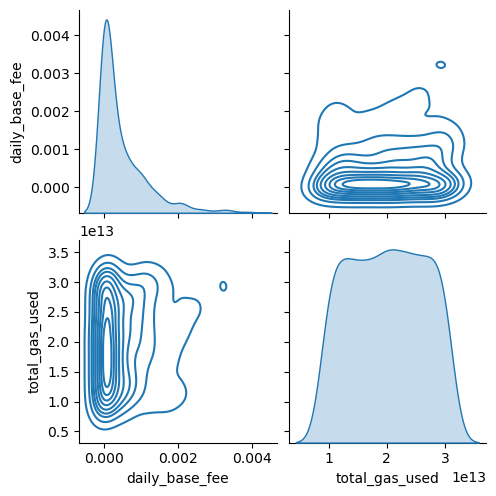

In [14]:
# plot to see what range of values the synthetic data covers
sns.pairplot(train_df_synthetic, kind='kde')

In [15]:
# build a copula model with the full dataset
copula_model_synth = gas_models.BivariateCopulaModel(train_df_synthetic[['daily_base_fee', 'total_gas_used']].values)
copula_model_synth.fit()
V = copula_model_synth.simulate_pseudoobs(nsamp=500)

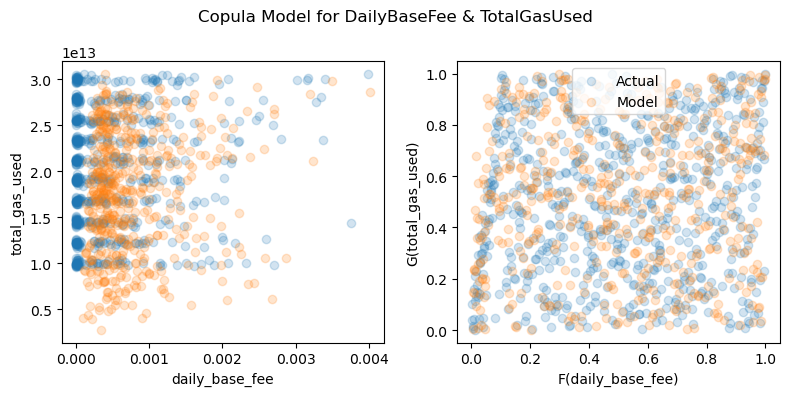

In [16]:
# plot the original pseudo-observations and the copula's for sanity checking
plt.figure(figsize=(8,4))

plt.subplot(121)
# TODO: show scatter plot in normal data scale
Y = copula_model_synth.pobs_to_obs(V)
plt.scatter(copula_model_synth.X[:,0], copula_model_synth.X[:,1], alpha=0.2, label='Actual')
plt.scatter(Y[:,0], Y[:,1], alpha=0.2, label='Model')
plt.xlabel('daily_base_fee')
plt.ylabel('total_gas_used')


plt.subplot(122)
plt.scatter(copula_model_synth.U[:,0], copula_model_synth.U[:,1], alpha=0.2, label='Actual')
plt.scatter(V[:,0], V[:,1], alpha=0.2, label='Model')
plt.xlabel('F(daily_base_fee)')
plt.ylabel('G(total_gas_used)')
plt.legend()

plt.suptitle('Copula Model for DailyBaseFee & TotalGasUsed')
plt.tight_layout()


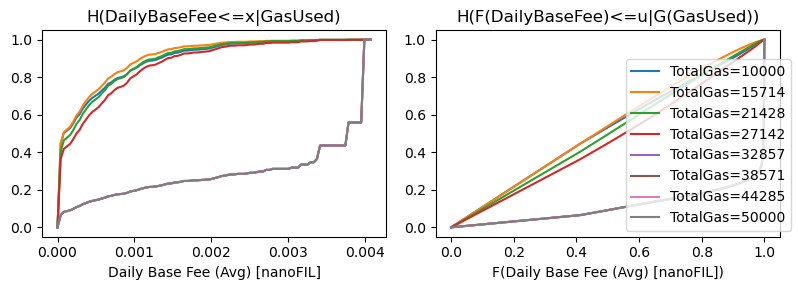

In [17]:
# generate conditional distribution functions 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))

gasused_vec = np.linspace(10000,50000,8)*1e9
for g in gasused_vec:
    marginal_var, marginal_var_pseudoobs, conditional_copula_cdf = \
        copula_model_synth.conditional_distribution(x=None, y=g, resolution=100)
    
    ax[0].plot(marginal_var, conditional_copula_cdf)
    ax[1].plot(marginal_var_pseudoobs, conditional_copula_cdf, label='TotalGas=%d' % (g//1e9,))

ax[0].set_xlabel('Daily Base Fee (Avg) [nanoFIL]')
ax[0].set_title('H(DailyBaseFee<=x|GasUsed)')
ax[1].set_xlabel('F(Daily Base Fee (Avg) [nanoFIL])')
ax[1].set_title('H(F(DailyBaseFee)<=u|G(GasUsed))')
fig.legend(loc='outside right center')

plt.tight_layout()

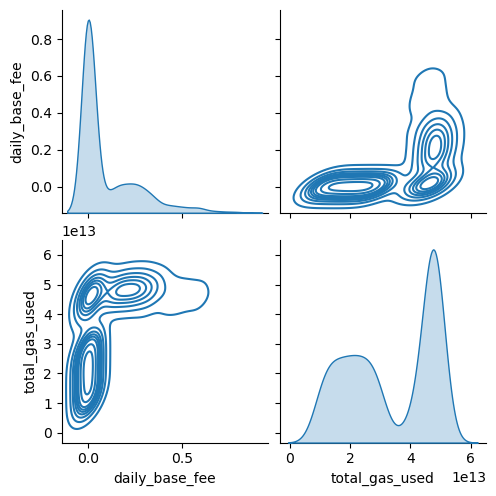

In [18]:
# combine the training data
train_df['type'] = 'real'
train_df_synthetic['type'] = 'synthetic'
train_df_full = pd.concat([train_df, train_df_synthetic], ignore_index=True)
sns.pairplot(train_df_full, kind='kde')

In [19]:
# build a copula model with the full dataset
copula_model_full = gas_models.BivariateCopulaModel(train_df_full[['daily_base_fee', 'total_gas_used']].values)
copula_model_full.fit()
V = copula_model_full.simulate_pseudoobs(nsamp=500)

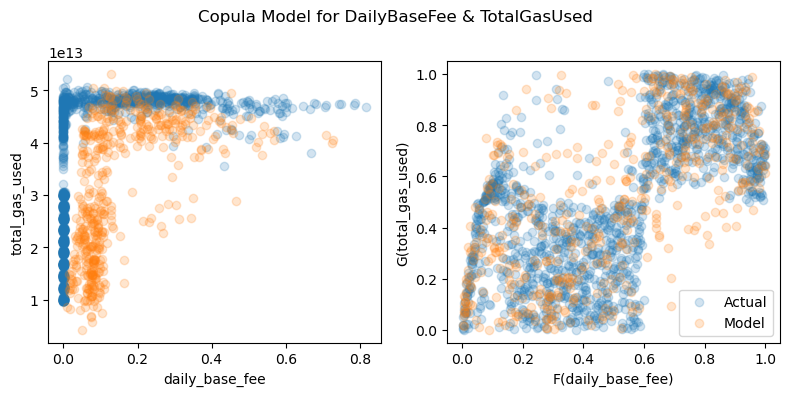

In [20]:
# plot the original pseudo-observations and the copula's for sanity checking
plt.figure(figsize=(8,4))

plt.subplot(121)
# TODO: show scatter plot in normal data scale
Y = copula_model_full.pobs_to_obs(V)
plt.scatter(copula_model_full.X[:,0], copula_model_full.X[:,1], alpha=0.2, label='Actual')
plt.scatter(Y[:,0], Y[:,1], alpha=0.2, label='Model')
plt.xlabel('daily_base_fee')
plt.ylabel('total_gas_used')

plt.subplot(122)
plt.scatter(copula_model_full.U[:,0], copula_model_full.U[:,1], alpha=0.2, label='Actual')
plt.scatter(V[:,0], V[:,1], alpha=0.2, label='Model')
plt.xlabel('F(daily_base_fee)')
plt.ylabel('G(total_gas_used)')
plt.legend()

plt.suptitle('Copula Model for DailyBaseFee & TotalGasUsed')
plt.tight_layout()


12500000000000.0 [0.00087254]
15000000000000.0 [0.00088286]
20000000000000.0 [0.00091493]
30000000000000.0 [0.00120277]
40000000000000.0 [0.00135013]
50000000000000.0 [0.07627144]


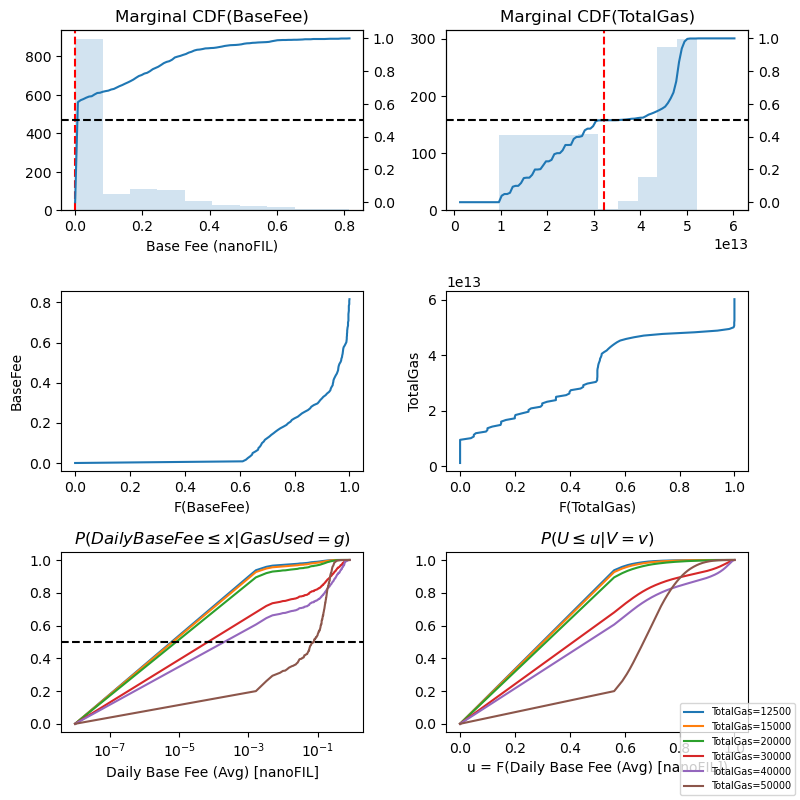

In [25]:
# generate conditional distribution functions 
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,8))

X = copula_model_full.X[:,0]
axx = ax[0,0]
axx.hist(X, alpha=0.2)
axx.axvline(np.median(X), color='r', linestyle='--')
axx.set_xlabel('Base Fee (nanoFIL)')
axx1 = axx.twinx()
lo = min(X)/8
hi = max(X) + np.median(X)/4
marginal_var = np.linspace(lo, hi, 100)
cdf_computed = copula_model_full.empirical_distributions[0](marginal_var)
# axx1.plot(marginal_var, copula_model_full.empirical_kdes[0].cdf)
axx1.plot(marginal_var, cdf_computed)
axx1.set_title('Marginal CDF(BaseFee)')
axx1.axhline(0.5, color='k', linestyle='--')

# plot inverse marginal cdfs for visualization
axx = ax[1,0]
axx.plot(cdf_computed, marginal_var)
axx.set_xlabel('F(BaseFee)')
axx.set_ylabel('BaseFee')

X = copula_model_full.X[:,1]
axx = ax[0,1]
axx.hist(X, alpha=0.2)
axx.axvline(np.median(X), color='r', linestyle='--')
axx1 = axx.twinx()
lo = min(X)/8
hi = max(X) + np.median(X)/4
marginal_var = np.linspace(lo, hi, 100)
# axx.plot(marginal_var/1e9, copula_model_full.empirical_kdes[1].cdf)
cdf_computed = copula_model_full.empirical_distributions[1](marginal_var)
axx1.plot(marginal_var, cdf_computed)
axx.set_title('Marginal CDF(TotalGas)')
axx1.axhline(0.5, color='k', linestyle='--')

axx = ax[1,1]
axx.plot(cdf_computed, marginal_var)
axx.set_xlabel('F(TotalGas)')
axx.set_ylabel('TotalGas')


gasused_vec = np.asarray([12500, 15000, 20000, 30000, 40000, 50000])*1e9
for g in gasused_vec:
    marginal_obs, marginal_var_pseudoobs, conditional_copula_cdf = \
        copula_model_full.conditional_distribution(x=None, y=g, resolution=500)
    ax[2,0].plot(marginal_obs, conditional_copula_cdf)  # plot data in observation space
    ax[2,1].plot(marginal_var_pseudoobs, conditional_copula_cdf, label='TotalGas=%d' % (g//1e9,))  # plot data in pseudo-obs space
    print(g, copula_model_full.quantile_conditional_distribution(x=None, y=g, resolution=500, qvec=[0.5]))

ax[2,0].set_xlabel('Daily Base Fee (Avg) [nanoFIL]')
ax[2,0].set_title(r'$P(DailyBaseFee \leq x|GasUsed=g)$')
ax[2,0].axhline(0.5, color='k', linestyle='--')
ax[2,0].set_xscale('log')
ax[2,1].set_xlabel('u = F(Daily Base Fee (Avg) [nanoFIL])')
ax[2,1].set_title(r'$P(U \leq u|V=v)$')
fig.legend(loc='outside right lower', fontsize=7)

plt.tight_layout()


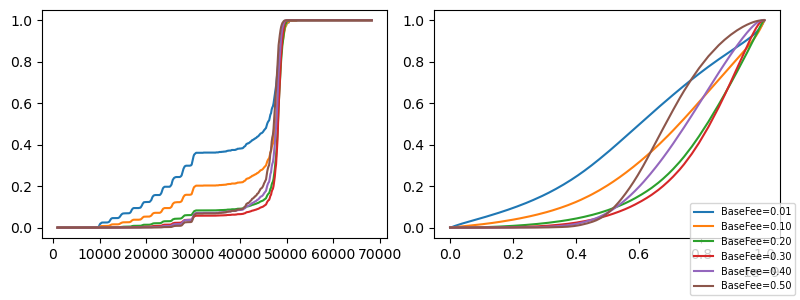

In [22]:
# test giving base-fee and computing inference on TotalGas
scale=1e-9
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))

basefee_vec = np.asarray([0.01, 0.1, 0.2, 0.3, 0.4, 0.5])
for b in basefee_vec:
    marginal_obs, marginal_var_pseudoobs, conditional_copula_cdf = \
        copula_model_full.conditional_distribution(x=b, y=None, resolution=500)
    ax[0].plot(marginal_obs*scale, conditional_copula_cdf)
    ax[1].plot(marginal_var_pseudoobs*scale, conditional_copula_cdf, label='BaseFee=%0.02f' % (b,))

# ax[2,0].set_xlabel('Daily Base Fee (Avg) [nanoFIL]')
# ax[2,0].set_title(r'$P(DailyBaseFee \leq x|GasUsed=g)$')
# ax[2,0].axhline(0.5, color='k', linestyle='--')
# ax[2,1].set_xlabel('u = F(Daily Base Fee (Avg) [nanoFIL])')
# ax[2,1].set_title(r'$P(U \leq u|V=v)$')
fig.legend(loc='outside right lower', fontsize=7)

plt.tight_layout()